In [65]:
import numpy as np
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt


In [66]:
data      = np.load("1-phase1/data/5j0n/angle_recovery_limited2.5_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

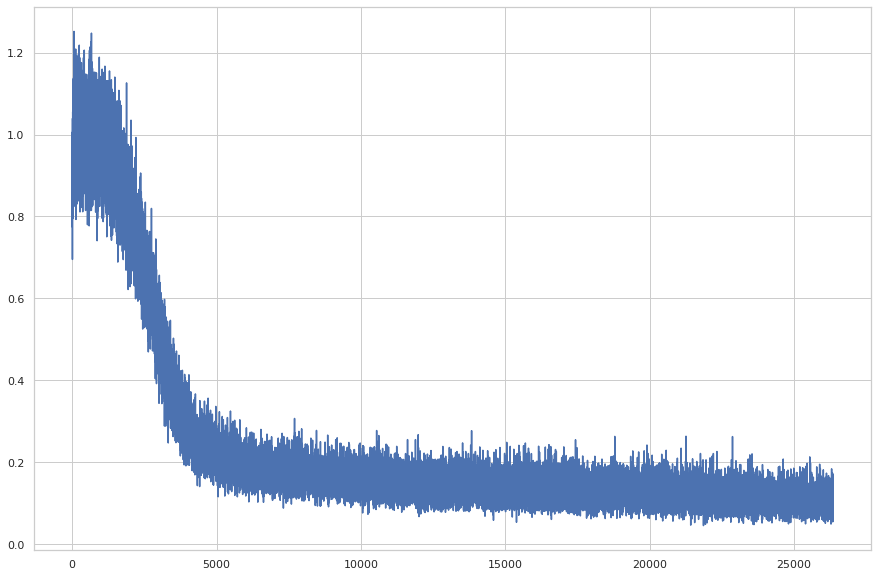

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[np.where(losses!=0.0)])
#plt.plot(np.arange(0, len(losses[np.where(losses!=0.0)]), 500),losses[np.where(losses!=0.0)][::500])
plt.show()

In [68]:
losses[np.where(losses!=0.0)][-1]

0.07742593229556155

In [69]:
np.min(losses[np.where(losses!=0.0)])

0.04527763715429823

In [70]:
np.argmin(losses[np.where(losses!=0.0)])

21863

In [26]:
type(losses[0])

numpy.float64

In [14]:
len(losses[np.where(losses!=0)])

21330

In [344]:
q_all.shape

(1501, 5000, 4)

In [345]:
losses.shape

(50000,)

In [346]:
losses_filtered = losses[np.where(losses!=0)][::10]
idx = np.argmin(losses_filtered)
q_predicted = q_all[idx]
losses_filtered.shape, idx, losses_filtered[idx],q_all[idx].shape

((1501,), 1006, 0.07614128963535345, (5000, 4))

---

In [357]:
# data      = np.load("1-phase1/data/5j0n/angle_recovery_estimated_le2_50k.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

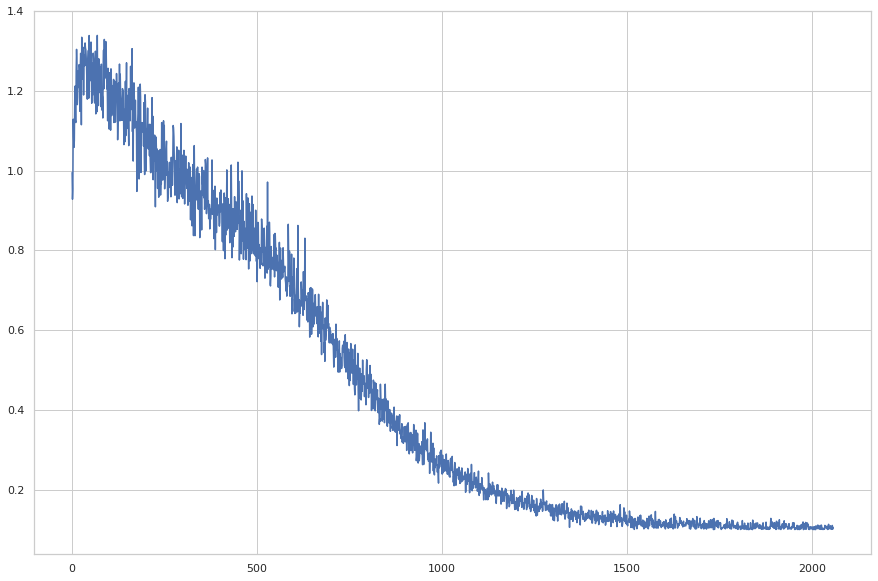

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[np.where(losses>0.1)])
plt.show()

In [39]:
np.min(losses[np.where(losses>0.1)])

0.10003359556461061

In [40]:
len(losses[np.where(losses>0.1)])

2057

---

In [36]:
data      = np.load("data/5j0n/angle_recovery_nuniform_mse.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

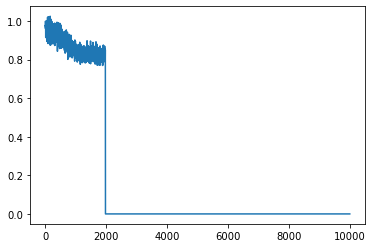

In [37]:
plt.plot(losses)

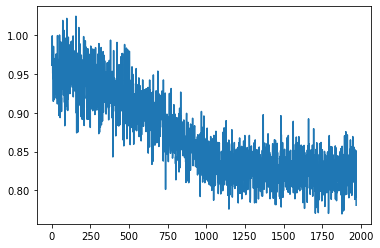

In [38]:
plt.plot(losses[np.where(losses>0.2)[0]])

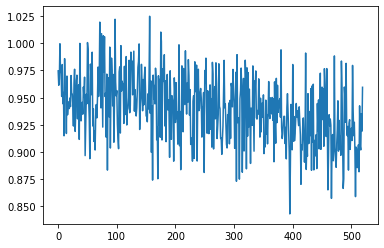

In [17]:
plt.plot(losses[np.where(losses>0.2)[0]])

In [ ]:
losses

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# strategy = tf.distribute.StrategyExtended()  #MirroredStrategy()
# with strategy.scope():



def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles


def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01): 

    time_start = time.time()
    
    BUFFER_SIZE = len(train_images)

    BATCH_SIZE_PER_REPLICA = 64
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    EPOCHS = 10
    
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)

    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    
    strategy = tf.distribute.MirroredStrategy()
    
    with strategy.scope():
    
        if q_predicted:
            # continue where left off
            q_predicted = [tf.Variable(q) for q in q_predicted]
        else:
            # optimize from scratch
            q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

        if in_data.shape[1] == 3:
            in_data = euler2quaternion(in_data)

        losses = np.empty(steps)
        report = f"Shape of projections: {in_data.shape}"
        found_minimizer = False

        print(time.time()-time_start)

        for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
            q1 = [q_predicted[i] for i in idx1]
            q2 = [q_predicted[i] for i in idx2]


            # Compute distances
            in1 = [in_data[i] for i in idx1]
            in2 = [in_data[i] for i in idx2]

            distance_target = distance_fn(in1, in2)

            # WORK ONLY WITH SMALL DISTANCES (<2.5)
            q1 = np.array(q1)
            q2 = np.array(q2)
            in1 = np.array(in1)
            in2 = np.array(in2)
            indices_le2 = np.where(distance_target<2.5)[0]
            distance_target = np.take(distance_target, indices_le2)
            q1 = list(np.take(q1, indices_le2))
            q2 = list(np.take(q2, indices_le2))
            in1 = list(np.take(in1, indices_le2))
            in2 = list(np.take(in2, indices_le2))

            # Optimize by gradient descent.
            losses[step-1], gradients = gradient(q1, q2, distance_target)
            optimizer.apply_gradients(zip(gradients, q1 + q2))

            # Visualize progress periodically
            if step % 10 == 0:
                a = np.zeros((len(q_predicted), 4))
                for i, e in enumerate(q_predicted):
                    a[i] = e.numpy()
                collect_data.append(a)

                if angles_true is not None:
                    fig, axs = plt.subplots(1, 3, figsize=(24,7))

                    # Optimization loss subplot
                    axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs[0].set_xlabel('time [s]')
                    axs[0].set_ylabel('loss');
                    axs[0].set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                    # NT - Distance count subplot (full)
                    d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                    axs[1].set_xlim(0, np.pi)
                    axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                    # T - Distance count subplot (full)
                    angles_true_T = angles_transpose(angles_true)
                    d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                    axs[2].set_xlim(0, np.pi)
                    axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                else:
                    fig, axs = plt.subplots(figsize=(10,7))

                    # Optimization loss subplot
                    axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs.set_xlabel('time [s]')
                    axs.set_ylabel('loss');
                    axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(0.1)

                np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))

                if found_minimizer:
                    time_elapsed = time.time() - time_start
                    report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                    break;

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

            if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
                found_minimizer = True

            if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
                found_minimizer = True

        print(report)
        return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)

def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")

        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))

        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))

            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random

        yield step, idx1, idx2

def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
    gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)

    return loss_value, gradient

